In [26]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import pandas as pd
from collections import Counter

# Pickle dump 
import pickle

In [2]:
lsjpeg  = lambda path   : [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpeg') or f.endswith('.jpg')]
norm    = lambda I      : cv2.normalize(I, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
read    = lambda f      : norm(cv2.imread(f, 0))
dct     = lambda I      : cv2.dct(I)
idct    = lambda I      : cv2.idct(I)
first   = lambda x      : int(str("{:.2e}".format(x))[0]) if x > 0 else 0
firsts  = lambda A      : [first(a) for a in A]
hist    = lambda I      : np.histogram(firsts(I.ravel()), bins=range(11))[0][1:]
pdf     = lambda h      : h/np.sum(h)
ben     = lambda        : np.log10(1 + 1/np.arange(1, 10))
ssd     = lambda A, B   : np.sum([pow(x-y,2) for x, y in zip(A, B)])

class plot:
    image       = lambda I   : plt.imshow(I, cmap='gray')
    
    @classmethod
    def multibar(cls, X, xticks=range(1,10), title=None):
        width = 1/(len(X)+1)
        for i, x in enumerate(X):
            x_axis = np.arange(1, len(x["data"])+1) + i*width
            plt.bar(x_axis, x["data"], width=width, label=x["name"])
        if title:
            plt.title(title)
        plt.xticks(xticks)
        plt.legend()
        plt.show()
    
    compare     = lambda f: plot.multibar([{"data": f, "name": "This"}, {"data": ben(), "name": "Benford"}])

    @classmethod
    def study1(cls, df, type='box', alpha=0.25, log=True):
        # Accumulate all dct_probs in a single list
        dct_probs = []
        for i in range(0, 9):
            dct_probs.append([])
        for j, r in df.iterrows():
            probs = list(r["analysis"]["dct"]["probs"])
            for i in range(0, 9):
                dct_probs[i].append(probs[i])
        
        if type == 'box':
            plt.boxplot(dct_probs)
            plt.xticks(range(1, 10))
        elif type == 'violin':
            plt.violinplot(dct_probs, showmeans=True, showmedians=False)
            plt.xticks(range(1, 10))
        
        if log: plt.yscale('log')
        plt.bar(range(1, 10), ben(), color='grey', alpha=0.15)
        plt.show()

    @classmethod
    def study2(cls, df, type='box', alpha=0.25, log=True):
        dct_probs = []
        for i in range(0, 9):
            dct_probs.append([])
        for j, r in df.iterrows():
            probs = list(r["analysis"]["dct"]["probs"])
            for i in range(0, 9):
                norm_prob = probs[i]/ben()[i]
                dct_probs[i].append(norm_prob)

        if type == 'box':
            plt.boxplot(dct_probs)
            plt.xticks(range(1, 10))
        elif type == 'violin':
            plt.violinplot(dct_probs, showmeans=True, showmedians=False)
            plt.xticks(range(1, 10))

        if log: plt.yscale('log')
        plt.show()
        
    @classmethod
    def study3(cls, df):
        errors = []
        for j, r in df.iterrows():
            error = r["analysis"]["dct"]["error"]
            errors.append(error)
        plt.hist(errors, bins=10)
        plt.show()


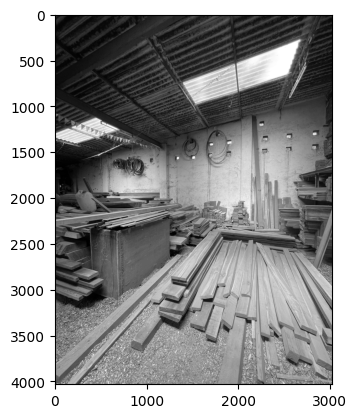

In [3]:
I = read('data/IMG_0026.jpeg')
plot.image(I)

In [ ]:
probs = pdf(hist(I))
error = ssd(probs, ben())

plot.compare(probs)
print(error)

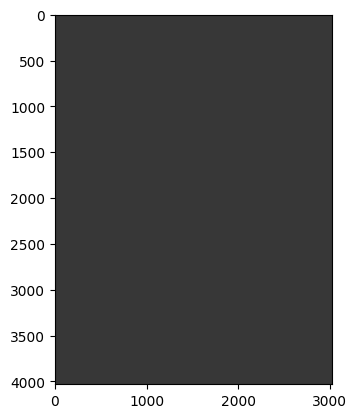

In [4]:
M = dct(I)
plot.image(M)

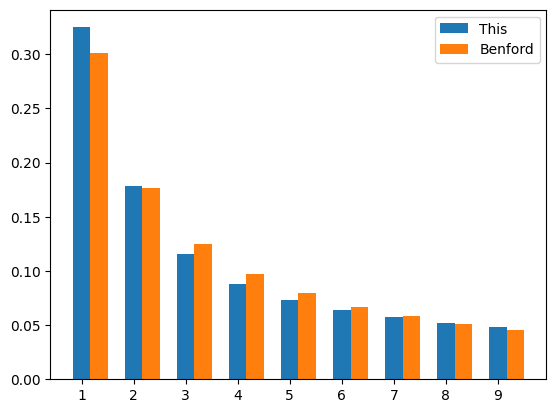

0.0007955814526799957


In [5]:
probs = pdf(hist(M))
error = ssd(probs, ben())

plot.compare(probs)
print(error)

In [6]:
def image_stats(file):
    I = read(file)
    pre_probs = pdf(hist(I))
    pre_error = ssd(pre_probs, ben())

    M = dct(I)
    dct_probs = pdf(hist(M))
    dct_error = ssd(dct_probs, ben())
    
    stats = { 
        "file": file, 
        "width": I.shape[1],
        "height": I.shape[0],
        "analysis": {
            "pre": {
                "probs": pre_probs,
                "error": pre_error
            }, 
            "dct": {
                "probs": dct_probs,
                "error": dct_error
            }
        }
    }

    return stats
    

In [ ]:
image_stats('data/IMG_0026.jpeg')

In [27]:
def batch_stats(files):
    batch = []

    for i, file in enumerate(files):
        print(f"Analysing file {i+1}/{len(files)} ..", end='\r')
        batch.append(image_stats(file))
    df = pd.DataFrame(batch)
    print(f"Analysing {i+1}/{len(files)} .. Done!")
    return df

In [40]:
files = lsjpeg('data')
stats = batch_stats(files[:3])

Analysing 3/3 .. Done!


In [29]:
# Save stats to pickle dump 
with open('stats.pkl', 'wb') as f:
    pickle.dump(stats, f)

In [30]:
# Load stats from pickle dump
with open('stats.pkl', 'rb') as f:
    stats = pickle.load(f)

In [31]:
stats

,file,width,height,analysis
0,data/IMG_0520.jpeg,4032,3024,"{'pre': {'probs': [0.10751960029060638, 0.2279..."
1,data/IMG_0465.jpeg,4032,3024,"{'pre': {'probs': [0.02949459869740165, 0.0930..."


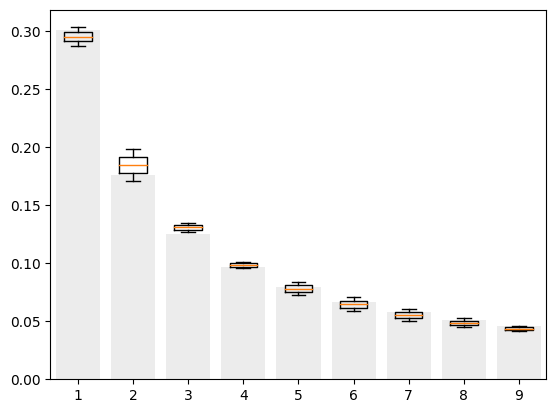

In [32]:
plot.study1(stats, type='box', log=False)

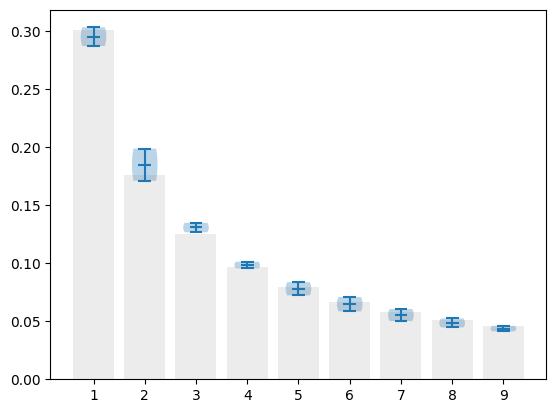

In [33]:
plot.study1(stats, type='violin', log=False)

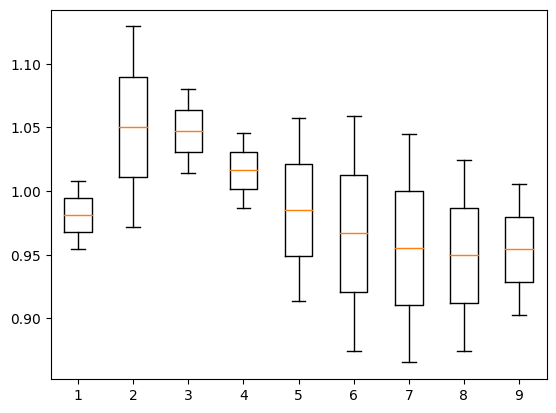

In [34]:
plot.study2(stats, type='box', log=False)

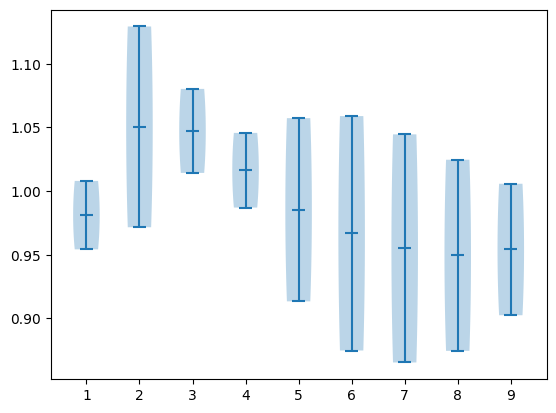

In [35]:
plot.study2(stats, type='violin', log=False)

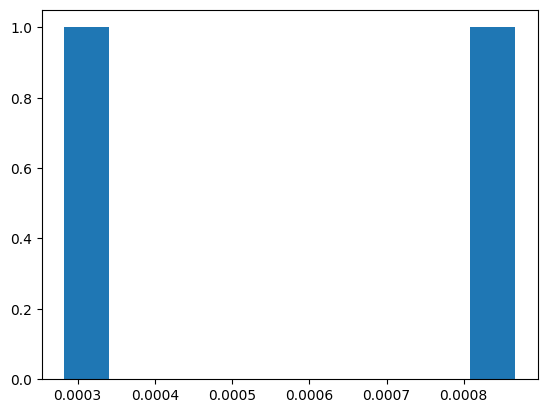

In [36]:
plot.study3(stats)